In [92]:
# Specify parameters for augmentation

audio_config = {}

audio_config['features_output_dir'] = 'hey_mycroft_validation_mmap'
# audio_config['features_output_dir'] = 'augmented_features_mmap'

audio_config['input_path'] = '/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/wake-word-benchmark/audio/alexa_trimmed'
# audio_config['input_path'] = '/Volumes/MachineLearning/audio_samples/recorded_samples/hey_mycroft/dataset_split/positive_samples'
# audio_config['input_path'] = 'generated_samples'
audio_config['input_glob'] = '*.wav'
# audio_config['input_glob'] = '*.wav'
audio_config['impulse_paths'] = None
# audio_config['background_paths'] = None
# audio_config['impulse_paths'] = ['mit_rirs']
audio_config['background_paths'] = None #['fma']
audio_config['min_clip_duration_s'] = None
audio_config['max_clip_duration_s'] = None
audio_config['max_start_time_from_right_s'] = None
audio_config['augmented_duration_s'] = 4.99

from microwakeword.feature_generation import ClipsHandler

# Load audio clips and prepare them for augmentation

clips_handler = ClipsHandler(
                            input_path=audio_config['input_path'],
                            input_glob=audio_config['input_glob'],
                            impulse_paths=audio_config['impulse_paths'], 
                            background_paths=audio_config['background_paths'], 
                            augmentation_probabilities = {
                                "SevenBandParametricEQ": 0.0,
                                "TanhDistortion": 0.0,
                                "PitchShift": 0.0,
                                "BandStopFilter": 0.0,
                                "AddColorNoise": 0.0,
                                "AddBackgroundNoise": 0.0,
                                "Gain": 0.0,
                                "RIR": 0.0,
                            },
                            augmented_duration_s = audio_config['augmented_duration_s'],
                            max_start_time_from_right_s = audio_config['max_start_time_from_right_s'],
                            max_clip_duration_s = audio_config['max_clip_duration_s'],   
                            min_clip_duration_s = audio_config['min_clip_duration_s'],     
                            max_jitter_s=0.91,
                            min_jitter_s=0.9,
                            remove_silence=False,
)

In [78]:
import IPython

clips_handler.save_random_augmented_clip("augmented_clip.wav")

IPython.display.display(IPython.display.Audio("augmented_clip.wav"))

In [94]:
import microwakeword.inference as inference
from tqdm import tqdm
import IPython
import numpy as np
import os
model = inference.Model('/Users/kahrendt/Documents/Hobbies/Programming/Git-Repositories/microWakeWord/notebooks/trained_models/alexa_mixconv_initial_conv8/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite')
# model = inference.Model('/Users/kahrendt/Documents/Hobbies/Programming/Git-Repositories/microWakeWord/models/alexa.tflite')
# model = inference.Model('/Users/kahrendt/Downloads/alexa_v2.tflite')
good_counter = 0
bad_counter = 0
all_counter = 0
truncated_clips = clips_handler.clips[:]['audio']
# truncated_clips = tqdm(clips_handler.clips)
# for clip in tqdm(truncated_clips[:100]):
for clip in tqdm(truncated_clips):
# for clip in tqdm(clips_handler.clips):
    # audio_data = clip["audio"]["array"]
    audio_data = clip["array"]
    spectrogram = clips_handler.generate_augmented_spectrogram(audio_data)
    # all_counter +=1
    probabilities = model.predict_spectrogram(spectrogram)#[-103:,:])
    if np.max(probabilities[-50:-30]) < 0.5:
    # if np.max(probabilities[-100:]) < 0.84:
        path_to_clip = clip['path']
        head, tail = os.path.split(path_to_clip)
        # renamed_path_clip = os.path.join(head, 'possibly_bad', tail)
        bad_counter += 1
        # print(tail)
    else:
        good_counter += 1
    
        
    # if not all_counter % 100:
    #     print(good_counter/all_counter)
        
        # os.rename(path_to_clip, renamed_path_clip)
        # print(tail, np.max(probabilities))

        # IPython.display.display(IPython.display.Audio(path_to_clip))
        # IPython.display.display(IPython.display.Audio(renamed_path_clip))
print(good_counter/len(truncated_clips))

100%|██████████| 315/315 [00:01<00:00, 160.39it/s]

0.9714285714285714


In [139]:
from microwakeword.feature_generation import ClipsHandler
import microwakeword.inference as inference
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

demand_path = '/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/demand'
demand_glob = 'D*/*.wav'
impulse_path = '/Users/kahrendt/Downloads/RIRS_NOISES/real_rirs_isotropic_noises'
impulse_glob = '*rir*.wav'

from pathlib import Path

background_clips_gen = Path(demand_path).glob(demand_glob)
background_clips = [str(i) for i in background_clips_gen]

impulse_clips_gen = Path(impulse_path).glob(impulse_glob)
impulses = [str(i) for i in impulse_clips_gen]

model = inference.Model('/Users/kahrendt/Documents/Hobbies/Programming/Git-Repositories/microWakeWord/notebooks/trained_models/alexa_mixconv_initial_conv4/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite')

real_alexa_handler = ClipsHandler(
                            input_path='/Users/kahrendt/Documents/Hobbies/Machine_Learning/wakeword_tflite/wake-word-benchmark/audio/alexa',
                            input_glob='*.flac',
                            # impulse_paths='mit_rirs', 
                            impulse_paths=impulses, 
                            background_paths=background_clips, 
                            augmentation_probabilities = {
                                "SevenBandParametricEQ": 0.0,
                                "TanhDistortion": 0.0,
                                "PitchShift": 0.0,
                                "BandStopFilter": 0.0,
                                "AddColorNoise": 0.0,
                                "AddBackgroundNoise": 1.0,
                                "Gain": 0.0,
                                "RIR": 1.0,
                            },
                            augmented_duration_s = 5.99,
                            max_start_time_from_right_s = None,
                            max_clip_duration_s = None,   
                            min_clip_duration_s = None,     
                            max_jitter_s=None,
                            min_jitter_s=0.5,
                            remove_silence=False,
                            background_min_db=10,
                            background_max_db=10,
)

from scipy.io import wavfile
index = 0
for _ in range(2):
    for clip in real_alexa_handler.clips:
        audio = clip["audio"]["array"]
        augmented_audio = real_alexa_handler.augment_clip(audio)
        
        fname = str(index) + ".wav"
        output_path = os.path.join('benchmark', 'alexa', fname)
        
        wavfile.write(output_path, 16000, augmented_audio)
        index += 1
        

# max_probs = []

# for clip in tqdm(real_alexa_handler.clips[:]['audio']):
#     audio_data = clip["array"]
#     spectrogram = real_alexa_handler.generate_augmented_spectrogram(audio_data)
#     probabilities = model.predict_spectrogram(spectrogram)
    
#     rolling_mean_probs = pd.Series(probabilities).rolling(10).mean()
#     # max_probs.append(np.max(probabilities[100:]))
#     max_probs.append(np.max(rolling_mean_probs[50:]))
    
# good_count = sum(i > 0.84 for i in max_probs)
# print(1-good_count/len(max_probs))


In [140]:
import openwakeword.model as model

path_to_clips = [str(i) for i in Path('benchmark/alexa').glob('*.wav')]

oww_model = model.Model(wakeword_models=['alexa'], inference_framework='onnx')
oww_max_probabilities = []
for clip_path in path_to_clips:
    predictions = oww_model.predict_clip(clip_path)
    test = [prediction['alexa'] for prediction in predictions]

    oww_max_probabilities.append(max(test[15:]))


In [100]:
good_count = sum(i > 0.86 for i in oww_max_probabilities)
print(1-good_count/len(oww_max_probabilities))

0.060317460317460325


In [141]:
from scipy.io import wavfile
model = inference.Model('/Users/kahrendt/Documents/Hobbies/Programming/Git-Repositories/microWakeWord/notebooks/trained_models/alexa_mixconv_initial_conv11/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite')
mww_probabilities = []
for clip_path in path_to_clips:
    _, wav_audio = wavfile.read(clip_path)
    useful_audio = (wav_audio).astype(np.int16)
    probabilities = model.predict_clip(useful_audio)
    rolling_mean_probs = pd.Series(probabilities).rolling(10).mean()
    # max_probs.append(np.max(probabilities[100:]))
    mww_probabilities.append(np.max(rolling_mean_probs[100:]))
# print(len(mww_probabilities))
# good_count = sum(i > 0.95 for i in mww_probabilities)
# print(1-good_count/len(mww_probabilities))    


mww_dipco_probabilities = model.predict_spectrogram(np.load('/Users/kahrendt/Documents/Hobbies/Programming/Git-Repositories/esphome-on-device-wake-word/dipco_features.npy'))
mww_dipco_list_probabilities = [mww_dipco_probabilities]
mww_dipco_false_accepts_per_hour = false_accept_test(mww_dipco_list_probabilities, 0.02, 75)

In [51]:
# oWW DipCo probabilities inferences
import openwakeword.model as model

path_to_clips = [str(i) for i in Path('/Volumes/MachineLearning/audio_samples/background_noise_samples/false_acceptance_tests/Dipco').glob('**/*U01.CH1.wav')]

oww_model = model.Model(wakeword_models=['alexa'], inference_framework='onnx')
dipco_probabilities = []
for clip_path in path_to_clips:
    predictions = oww_model.predict_clip(clip_path)
    test = [prediction['alexa'] for prediction in predictions]

    dipco_probabilities.append(test)

In [108]:
# oWW DipCo evluation


def running_average_detection(window_probability, thresholds):
    boolean_detection = window_probability > thresholds

    return boolean_detection
ignore_after_positive_setting = 25
cutoffs = np.arange(0.05, 1, 0.01)
true_accepts = np.zeros(cutoffs.shape[0])
false_accepts = np.zeros(cutoffs.shape[0])
cooldown_periods = np.ones(cutoffs.shape[0])
cooldown_periods = np.maximum(cooldown_periods - 1, np.zeros(cutoffs.shape[0]))

probabilities_duration_h = 0 
for probs in dipco_probabilities:
    probabilities_duration_h += len(probs)*0.08/3600.0
    for prob_index in range(25, len(probs)):
        cooldown_periods = np.maximum(cooldown_periods - 1, np.zeros(cutoffs.shape[0]))
        detected = running_average_detection(probs[prob_index], cutoffs)

        for index, detection_bool in enumerate(detected):
            if cooldown_periods[index] <= 0:
                if detection_bool:
                    cooldown_periods[index] = ignore_after_positive_setting
                    
                    false_accepts[index] +=1
                    
oww_dipco_false_accepts_per_hour = false_accepts/probabilities_duration_h
for i in range(0, oww_dipco_false_accepts_per_hour.shape[0]):
    print("Cutoff =", cutoffs[i], "; faph =", oww_dipco_false_accepts_per_hour[i])
print(probabilities_duration_h)

10
Cutoff = 0.05 ; faph = 18.538554367275605
Cutoff = 0.060000000000000005 ; faph = 15.167908118680039
Cutoff = 0.07 ; faph = 12.92081061961633
Cutoff = 0.08000000000000002 ; faph = 11.984519995006451
Cutoff = 0.09000000000000001 ; faph = 10.860971245474596
Cutoff = 0.1 ; faph = 9.36290624609879
Cutoff = 0.11000000000000001 ; faph = 8.801131871332862
Cutoff = 0.12000000000000001 ; faph = 8.052099371644958
Cutoff = 0.13 ; faph = 7.864841246722984
Cutoff = 0.14 ; faph = 7.303066871957056
Cutoff = 0.15000000000000002 ; faph = 6.741292497191129
Cutoff = 0.16000000000000003 ; faph = 6.366776247347177
Cutoff = 0.17000000000000004 ; faph = 5.80500187258125
Cutoff = 0.18000000000000005 ; faph = 5.80500187258125
Cutoff = 0.19 ; faph = 5.243227497815322
Cutoff = 0.2 ; faph = 5.243227497815322
Cutoff = 0.21000000000000002 ; faph = 4.868711247971371
Cutoff = 0.22000000000000003 ; faph = 4.681453123049395
Cutoff = 0.23000000000000004 ; faph = 4.681453123049395
Cutoff = 0.24000000000000005 ; faph = 

In [124]:
def false_accept_test(probabilities, stride, ignore_after_positive_setting):
    def running_average_detection(window_probability, thresholds):
        boolean_detection = window_probability > thresholds

        return boolean_detection
    
    cutoffs = np.arange(0.05, 1, 0.01)
    false_accepts = np.zeros(cutoffs.shape[0])
    cooldown_periods = np.ones(cutoffs.shape[0])
    cooldown_periods = np.maximum(cooldown_periods - 1, np.zeros(cutoffs.shape[0]))

    probabilities_duration_h = 0 
    

    for probs in probabilities:
        probabilities_duration_h += len(probs)*stride/3600.0
        for prob_index in range(25, len(probs)):
            cooldown_periods = np.maximum(cooldown_periods - 1, np.zeros(cutoffs.shape[0]))
            detected = running_average_detection(probs[prob_index], cutoffs)

            for index, detection_bool in enumerate(detected):
                if cooldown_periods[index] <= 0:
                    if detection_bool:
                        cooldown_periods[index] = ignore_after_positive_setting
                        
                        false_accepts[index] +=1

    return false_accepts/probabilities_duration_h

In [126]:
oww_dipco_false_accepts_per_hour = false_accept_test(dipco_probabilities, 0.08, 25)


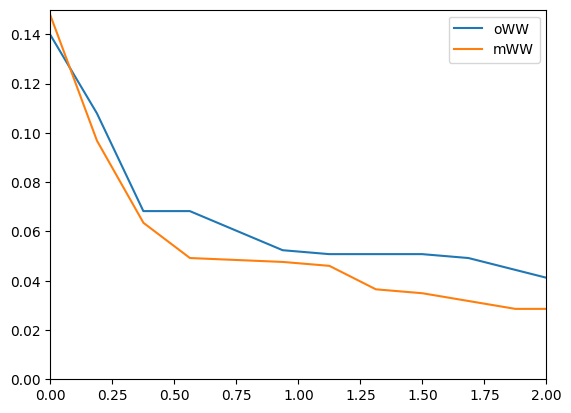

In [142]:
roc_curve_pairs = [(oww_dipco_false_accepts_per_hour, oww_max_probabilities, "oWW"),
                   (mww_dipco_false_accepts_per_hour, mww_probabilities, "mWW")]

curve_coordinates = []

for prob_pair in roc_curve_pairs:
    false_accepts_per_hour = prob_pair[0]

    false_negatives = []

    for cutoff in cutoffs:
        good_count = sum(i > cutoff for i in prob_pair[1])
        false_negatives.append(1-good_count/len(prob_pair[1]))

    if false_accepts_per_hour[0] > 2:
        # Use linear interpolation to estimate recall at 2 faph
        
        # Increase index until we find a faph less than 2
        index_of_first_viable = 1
        while false_accepts_per_hour[index_of_first_viable] > 2:
            index_of_first_viable +=1
        
        x0 = false_accepts_per_hour[index_of_first_viable-1]
        y0 = false_negatives[index_of_first_viable-1]
        x1 = false_accepts_per_hour[index_of_first_viable]
        y1 = false_negatives[index_of_first_viable]
        
        fnr_at_2faph = (y0*(x1-2.0)+y1*(2.0-x0))/(x1-x0)
    else:
        # Lowest faph is already under 2, assume the recall is constant before this
        index_of_first_viable = 0
        fnr_at_2faph = false_negatives[0]
        
    x_coordinates = [2.0]
    y_coordinates = [fnr_at_2faph]
        
    for index in range(index_of_first_viable, len(false_negatives)):
        if false_accepts_per_hour[index] != x_coordinates[-1]:
            # Only add a point if it is a new faph
            # This ensures if a faph rate is repeated, we use the highest recall
            x_coordinates.append(false_accepts_per_hour[index])
            y_coordinates.append(false_negatives[index])

    curve_coordinates.append({
        'x_coordinates': np.flip(x_coordinates),
        'y_coordinates': np.flip(y_coordinates),
        'label': prob_pair[2],
    })
    
    
import matplotlib.pyplot as plt

plt.axis((0,2.0,0,0.15))
for curve in curve_coordinates:
    # print(curve['x_coordinates'])
    plt.plot(curve['x_coordinates'],curve['y_coordinates'], label=curve['label'])
plt.legend()
plt.show()

In [5]:
from pathlib import Path
import datasets
import microwakeword.inference as inference
import numpy as np

path_to_clips = [str(i) for i in Path('/Volumes/MachineLearning/audio_samples/recorded_samples/hey_mycroft').glob('personal_samples/*.wav')]

audio_dataset = datasets.Dataset.from_dict(
            {"audio": [str(i) for i in path_to_clips]}
        ).cast_column("audio", datasets.Audio())

# model = inference.Model('/Users/kahrendt/Documents/Hobbies/Machine_Learning/microwakeword/trained_models/hey_mycroft_wide_matchbox_filtered/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite')
model = inference.Model('/Users/kahrendt/Documents/Hobbies/Programming/Git-Repositories/microWakeWord/notebooks/trained_models/hey_mycroft_mixednet_no_initial_conv2/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite')

for clip in audio_dataset:
    null_audio = np.zeros(16*40*20).astype(np.int16)
    # null_audio = np.zeros(16*74*20).astype(np.int16)

    audio = clip["audio"]["array"]
    useful_audio = (audio * 32767).astype(np.int16)

    useful_audio = np.append(null_audio, useful_audio)
    useful_audio = np.append(useful_audio, null_audio)

    probabilities = model.predict_clip(useful_audio)
    # print(clip)
    # print(max(probabilities[50:]))
    if np.max(probabilities[50:]) < 0.5:
        print(np.max(probabilities[50:]))
        print(clip['audio']['path'])

# import wave
# with wave.open('/Volumes/MachineLearning/audio_samples/recorded_samples/hey_mycroft/28.wav') as input_wav:
#     wav_audio =input_wav.readframes(input_wav.getnframes())

# import scipy.io.wavfile as wav

# null_audio = np.zeros(16*20*20).astype(np.int16)
# second_null_audio = np.zeros(16*6*20).astype(np.int16)

# _, wav_audio = wav.read('/Volumes/MachineLearning/audio_samples/recorded_samples/hey_mycroft/personal_samples/31.wav')
# useful_audio = (wav_audio).astype(np.int16)
# useful_audio = np.append(null_audio, useful_audio)
# useful_audio = np.append(useful_audio, second_null_audio)
# probabilities = model.predict_clip(useful_audio)
# import matplotlib.pyplot as plt
# print(np.max(probabilities[100:]))
# plt.plot(probabilities[:])



0.0625
/Volumes/MachineLearning/audio_samples/recorded_samples/hey_mycroft/personal_samples/23.wav
0.375
/Volumes/MachineLearning/audio_samples/recorded_samples/hey_mycroft/personal_samples/32.wav


In [3]:
import openwakeword.utils as utils
import openwakeword.model as model
from tqdm import tqdm
from pathlib import Path

# path_to_clips = [str(i) for i in Path('/Users/kahrendt/Documents/Hobbies/Programming/Git-Repositories/piper-sample-generator/output/mycroft/small').glob('*.wav')]
path_to_clips = [str(i) for i in Path('/Volumes/MachineLearning/audio_samples/recorded_samples/hey_mycroft/personal_samples').glob('*.wav')]

model = model.Model(wakeword_models=['hey mycroft'], inference_framework='onnx')
truncated_clips = clips_handler.clips[:]['audio']
# print(truncated_clips[0]['array'])
# good_counter = 0
bad_counter = 0
good_counter = 0
max_probabilties = []
for clip in tqdm(truncated_clips):
    # print(clip)
    audio_data = clip['array']
    audio_path = clip['path']
    # audio_data = clip["audio"]["array"]
    # spectrogram = clips_handler.generate_augmented_spectrogram(audio_data)
    predictions = model.predict_clip(audio_path)
    test = [prediction['hey mycroft'] for prediction in predictions]
    # print(test)
    max_probabilties.append(max(test))
    if (max(test) < 0.5):
        # print(max(test))
        # print(clip['path'])
        bad_counter +=1
    else:
        good_counter +=1

print(good_counter/len(truncated_clips))

# for clip in path_to_clips:
#     predictions = model.predict_clip(clip)
#     test = [prediction['hey mycroft'] for prediction in predictions]
#     # print(max(test))
#     if (max(test) < 0.5):
#         print(max(test))
#         print(clip)
# utils.download_models()
# utils.bulk_predict(path_to_clips, ['hey mycroft'], inference_framework='onnx')

100%|██████████| 10771/10771 [1:07:31<00:00,  2.66it/s]

0.7622319190418717


In [5]:
import numpy as np
with open('mycroft_real_samples_oww_max_prob.npy', 'wb') as f:
    np.save(f, np.array(max_probabilties))

In [ ]:
import microwakeword.inference as inference
import scipy.io.wavfile as wav
import numpy as np
model = inference.Model('/Users/kahrendt/Documents/Hobbies/Programming/Git-Repositories/microWakeWord/notebooks/trained_models/hey_mycroft_better_rs/tflite_stream_state_internal_quant/stream_state_internal_quant.tflite')
_, wav_audio = wav.read('/Volumes/MachineLearning/audio_samples/recorded_samples/hey_mycroft/7.wav')
useful_audio = (wav_audio).astype(np.int16)
# useful_audio = np.append(null_audio, useful_audio)
with open("audio_raw.bin", "wb") as binary_file:
    binary_file.write(useful_audio.tobytes())
    
# from microwakeword.feature_generation import generate_features_for_clip
# spectrogram, chunk = generate_features_for_clip(useful_audio)



probabilities, chunk = model.predict_clip(useful_audio)
# useful_audio = np.append(useful_audio, null_audio)
print(chunk.shape)
for frame in range(chunk.shape[0]):
    for i in range(0,40):
        print(chunk[frame][i], end=' ')
    print('\n')
# import matplotlib.pyplot as plt
# print(np.max(probabilities[74:]))
# plt.plot(probabilities[:])
